In [2]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4

'%.4f'

# Psedorandom number generators

While psuedorandom numbers are generated by a deterministic algorithm, we can mostly treat them as if they were true random numbers and we will drop the “pseudo” prefix. Fundamentally, the algorithm generates random integers which are then normalized to give a floating point number from the standard uniform distribution. Random numbers from other distributions are in turn generated using these uniform random deviates, see later.

## Linear congruential generators (LCG)

[LCG](https://en.wikipedia.org/wiki/Linear_congruential_generator) is among the simplest and most popular pseudo random number generators. It relies on the recursive and fully deterministic relation:

$$
z_i+1=(a z_i+c)\mod{m}
$$

Hull-Dobell Theorem: The LCG will have a period $m$ for all seeds if and only if

* $c$ and $m$ are relatively prime,
* $a−1$ is divisible by all prime factors of $m$
* $a−1$ is a multiple of 4 if $m$ is a multiple of $4$.

The number $z0$ is called the *seed*, and setting it allows us to have a reproducible sequence of (pseudo) random numbers. The LCG is typically coded to return $z/m$, a floating point number in $(0, 1)$. Obviosuly, this can be easily scaled to any other range $(a,b)$.
Note that $z \le m-1$ always holds, the yielded $z/m$ result is thus on purpose strictly smaller than 1. 



In [3]:
def lcg(m=2**32, a=1103515245, c=12345):
    lcg.current = (a*lcg.current + c) % m
    return lcg.current/m

# setting the seed
lcg.current = 12346

In [4]:
[lcg() for i in range(10)]

[0.0845,
 0.4127,
 0.3394,
 0.9832,
 0.6787,
 0.0724,
 0.4075,
 0.4970,
 0.1907,
 0.6211]

0.4577052230807021
0.27061015523463205 0.2886751345948129


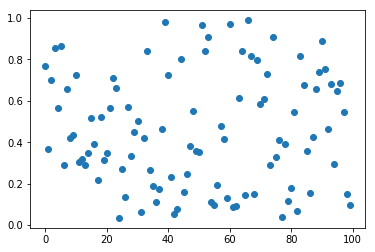

In [5]:
rn=[lcg() for i in range(100)]
print (np.mean(rn))
print (np.std(rn),1/np.sqrt(12))
plt.plot(rn,"o")


LCG though is not sufficiently "random" for several complex modern applications. Nowadays the algorithm [Mersenne twister](https://en.wikipedia.org/wiki/Mersenne_Twister), a generalized feedback shift-register generator, is used, in particular the numpy random package features it.


# Non-uniform random numbers

In several cases the actual random process occur with non-uniform probability, i.e. with a given probability density function (pdf), different from the uniform distribution. Several methods are available, we will see a few of them

### Inverst transform method

Let'start from a uniform distribution $u(z)$:

$$
\left\{
\begin{array}{ll}
      1 & 0\leq z\leq 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

and let's look for a function $x(z)$ such that $x$ is distributed accordingly to a given pdf $p(x)$. The probability to find $x$ between $x$ and $x+dx$ is equal to:

$$
p(x)dx = dz
$$

and thus:

$$
\int_{-\infty}^{x(z)} p(x') dx' = \int_0^z dz'= z
$$

If (a) we could solve the integral and (b) solve for $x$ then we are done. For most of the pdf at least one of the two is not possible.. The typical solvable analitical example is:

$$
p(x) = \mu e^{-\mu x}
$$

$$
\int_{0}^{x(z)} p(x') dx' = 1 - e^{-\mu x} = z
$$

and thus:

$$
x(z) = - \frac{1}{\mu}\log{1-z}
$$

In [6]:
def expon_pdf(x, mu=1):
    """PDF of exponential distribution."""
    return mu*np.exp(-mu*x)

def expon_cdf(x, mu=1):
    """CDF of exponetial distribution."""
    return 1 - np.exp(-mu*x)

def expon_icdf(p, mu=1):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -np.log(1-p)/mu

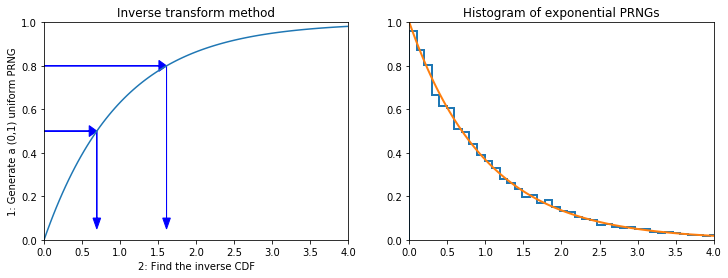

In [7]:
dist = stats.expon()
x = np.linspace(0,4,100)
y = np.linspace(0,1,100)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x, expon_cdf(x))
plt.axis([0, 4, 0, 1])
for q in [0.5, 0.8]:
    plt.arrow(0, q, expon_icdf(q)-0.1, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
    plt.arrow(expon_icdf(q), q, 0, -q+0.1, head_width=0.1, head_length=0.05, fc='b', ec='b')
plt.ylabel('1: Generate a (0,1) uniform PRNG')
plt.xlabel('2: Find the inverse CDF')
plt.title('Inverse transform method');

plt.subplot(122)
u = np.random.random(10000)
v = expon_icdf(u)
plt.hist(v, histtype='step', bins=100, density=True, linewidth=2)
plt.plot(x, expon_pdf(x), linewidth=2)
plt.axis([0,4,0,1])
plt.title('Histogram of exponential PRNGs');

### Box-Muller for generating normally distributed random numbers

The inverse method is not applicable even for the gaussian distribution:

$$
\frac{1}{\sqrt{2\pi\sigma^2}}\int_{-\infty}^{x} \exp{-\frac{x'^2}{2\sigma^2}} dx' = z
$$

is not solvable. The trick is to consider a two dimensional gaussian function with the same $\sigma$ on both coordinates:

$$
p(x)dx \times p(y)dy = \frac{1}{\sqrt{2\pi\sigma^2}} \exp{-\frac{x^2}{2\sigma^2}} \times \frac{1}{\sqrt{2\pi\sigma^2}} \exp{-\frac{y^2}{2\sigma^2}} = \frac{1}{2\pi\sigma^2} \exp{-\frac{(x^2+y^2)}{2\sigma^2}}dxdy
$$

which written in radial coordinates:

$$
x=r\cos{\theta};\,\,\,
y=r\sin{\theta}
$$

$$
p(r,\theta)dr d\theta = \frac{r}{\sigma^2} \exp{-\frac{r^2}{2\sigma^2}} dr \times \frac{d\theta}{2\pi} = p(r)dr \times p(\theta)d\theta
$$

with both $p(r)$ and $p(\theta)$ normalized to 1. Now, the latter is a simple uniform distribution, whereas the latter is solvable:

$$
\frac{1}{\sigma^2} \int_{0}^{r} \exp{-\frac{r^2}{2\sigma^2}} rdr = z
$$

which gives:

$$
r=\sqrt{-2\sigma^2\log{1-z}}
$$


In [8]:
n = 1000
z = np.random.random(n)
theta = 2*np.pi*np.random.random(n)
r_squared = -2*np.log(z)
r = np.sqrt(r_squared)
x = r*np.cos(theta)
y = r*np.sin(theta)

/opt/ubuntu-16.04/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


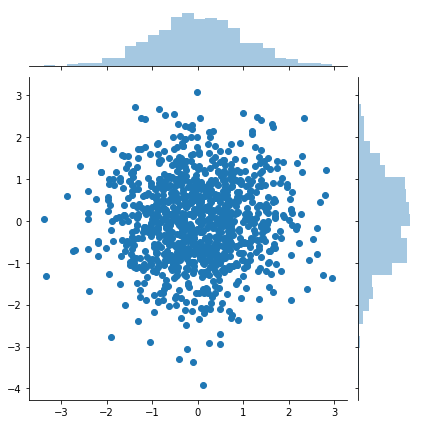

In [9]:
sns.jointplot(x,y, kind='scatter');


### Creating a random number generator for arbitrary distributions

Suppose we have some random samples with an unknown distribtuion. We can still use the inverse transform method to create a random number generator from a random sample, by estimating the inverse CDF function using interpolation.

In [10]:
from scipy.interpolate import interp1d

def extrap1d(interpolator):
    """From StackOverflow http://bit.ly/1BjyRfk"""
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return np.array(list(map(pointwise, np.array(xs))))

    return ufunclike

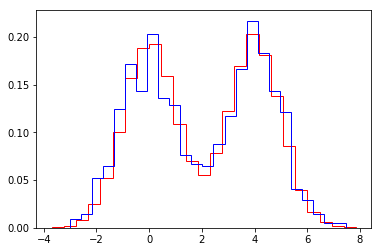

In [11]:
from statsmodels.distributions.empirical_distribution import ECDF

# Make up some random data
x = np.concatenate([np.random.normal(0, 1, 10000),
                    np.random.normal(4, 1, 10000)])

ecdf = ECDF(x)
inv_cdf = extrap1d(interp1d(ecdf.y, ecdf.x,
                            bounds_error=False, assume_sorted=True))
r = np.random.uniform(0, 1, 1000)
ys = inv_cdf(r)

plt.hist(x, 25, histtype='step', color='red', density=True, linewidth=1)
plt.hist(ys, 25, histtype='step', color='blue', density=True, linewidth=1);

### Rejection sampling (Accept-reject method)

Suppose we want to sample from the (truncated) T distribution witb 10 degrees of freedom.
We use the uniform as a proposal distibution (highly inefficient)


In [ ]:
x = np.linspace(-4, 4)

df = 10
dist = stats.cauchy()
upper = dist.pdf(0)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x, dist.pdf(x))
plt.axhline(upper, color='grey')
px = 1.0
plt.arrow(px,0,0,dist.pdf(1.0)-0.01, linewidth=1,
         head_width=0.2, head_length=0.01, fc='g', ec='g')
plt.arrow(px,upper,0,-(upper-dist.pdf(px)-0.01), linewidth=1,
         head_width=0.3, head_length=0.01, fc='r', ec='r')
plt.text(px+.25, 0.2, 'Reject', fontsize=16)
plt.text(px+.25, 0.01, 'Accept', fontsize=16)
plt.axis([-4,4,0,0.4])
plt.title('Rejection sampling concepts', fontsize=20)

plt.subplot(122)
n = 100000
# generate from sampling distribution
u = np.random.uniform(-4, 4, n)
# accept-reject criterion for each point in sampling distribution
r = np.random.uniform(0, upper, n)
# accepted points will come from target (Cauchy) distribution
v = u[r < dist.pdf(u)]

plt.plot(x, dist.pdf(x), linewidth=2)

# Plot scaled histogram
factor = dist.cdf(4) - dist.cdf(-4)
hist, bin_edges = np.histogram(v, bins=100, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.step(bin_centers, factor*hist, linewidth=2)

plt.axis([-4,4,0,0.4])
plt.title('Histogram of accepted samples', fontsize=20);


### Mixture representations
Sometimee, the target distribution from which we need to generate random numbers can be expressed as a mixture of “simpler” distributions that we already know how to sample from

$$
f(x)=\int g(x|y)p(y)dy
$$

For example, if $y$ is drawn from the $\chi^2_\nu$ distrbution, then ${\cal N}(0,\nu/y)$ is a sample from the Student’s T distribution with $\nu$ degrees fo freedom.

In [ ]:
n = 10000
df = 5
dist = stats.t(df=df)
y = stats.chi2(df=df).rvs(n)
r = stats.norm(0, df/y).rvs(n)


plt.plot(x, dist.pdf(x), linewidth=2)

# Plot scaled histogram
factor = dist.cdf(4) - dist.cdf(-4)
hist, bin_edges = np.histogram(v, bins=100, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.step(bin_centers, factor*hist, linewidth=2)

plt.axis([-4,4,0,0.4])
plt.title('Histogram of accepted samples', fontsize=20);

### Draw from an analytic pdf

Obviously scipy stats module features all possible pdf that can come to your mind. You can draw random data from each of them

In [ ]:
from scipy.stats import gamma
a = 1.99

x = np.linspace(gamma.ppf(0.01, a),
                gamma.ppf(0.99, a), 100)
rv = gamma(a)
fig, ax = plt.subplots(1, 1)
ax.plot(x, rv.pdf(x), 'k-', lw=2)
r = gamma.rvs(a, size=1000)
_ = ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)

# Monte Carlo integration

Monte Carlo integration is typically less accurate than other integration methods, but very often is the only available tool, e.g. when the integrand has very rapid variations or singular points, or, most importantly, when dealing with high dimensional integrals.

The idea is simple, let's the area under the function be $I$ whereas the all possible outcomes lay in a box of area $A$. The probability for a point to fall under the function is $p=I/A$. If we generate $N$ random points, the fraction $k$ which fall under the curve is $k/N$ and approximate $I/A$, thus:

$$
I\simeq\frac{k A}{N}
$$

Let's try this with the function $f(x) =\sin^2{\frac{1}{x(2-x)}}$

In [ ]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(0.001,1.999,1000)
plt.plot(x,f(x),'r-')

In [ ]:
# Monte Carlo integration
N=100000
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=2*count/N
print(I)

### The mean value method

Let's take the integral:

$$
I=\int_a^b f(x) dx
$$

defining $\langle f \rangle$ as the mean of $f$:

$$
\langle f \rangle = \frac{1}{b-a}\int_a^b f(x) dx
$$

and estimating $\langle f \rangle$ by uniformely probing at random the function domain we get:

$$
I=\frac{a-b}{N} \sum_{i=1}^{N} f(x_i)
$$

this easily generalize to higher dimensions:

$$
I=\frac{V}{N} \sum_{i=1}^{N} f(\vec{r}_i)
$$

where the sampling points $\vec{r}_i$ are drawn uniformly at random from integration space of volume $V$.

It can be proven that the standard deviation of the method scales $1/\sqrt{N}$:

$$
\sigma = V\frac{\sqrt{{\rm var}\, f}}{\sqrt{N}}
$$

### Importance sampling

There are several general techinques for variance reduction, sometimes known as Monte Carlo swindles since these methods improve the accuracy and convergene rate of Monte Carlo integration without increasing the number of Monte Carlo samples. *Importance sampling* is among the most commonly used.

We can define a weighted average of a function $g(x)$:

$$
\langle g_w \rangle = \frac{\int_a^b w(x) g(x)dx}{\int_a^b w(x)dx}
$$

Consider again the integral of $f(x)$:

$$
I=\int_a^b f(x)dx
$$

Setting $g(x)=f(x)/w(x)$ we have:

$$
\left\langle \frac{f(x)}{w(x)}\right\rangle = \frac{\int_a^b w(x)f(x)/w(x) )dx}{\int_a^b w(x)dx} = \frac{I}{\int_a^b w(x)dx}
$$

and thus:

$$
I = \left\langle \frac{f(x)}{w(x)}\right\rangle \int_a^b w(x)dx \simeq \frac{1}{N}\sum_{i=1}^N \frac{f(x_i)}{w(x_i)}\int_a^b w(x)dx
$$

which generalizes the mean value method if $w(x)$ is the uniform distribution between $a$ and $b$

### Example

Suppose we want to estimate the tail probability of ${\cal N}(0,1)$ for $P(x>5)$. Regular MC integration using samples from ${\cal N}(0,1)$ is hopeless since nearly all samples will be rejected. However, we can use the exponential density truncated at 5 as the importance function and use importance sampling.

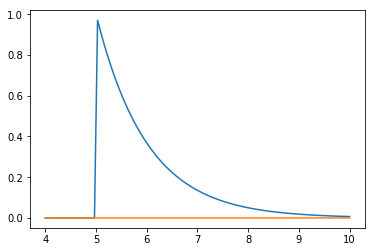

In [12]:
x = np.linspace(4, 10, 100)
plt.plot(x, stats.expon(5).pdf(x))
plt.plot(x, stats.norm().pdf(x));

In [13]:
%precision 10
h_true =1 - stats.norm().cdf(5)
h_true

0.0000002867

In [14]:
n = 1000000
y = stats.norm().rvs(n)
h_mc = 1.0/n * np.sum(y > 5)
# estimate and relative error
h_mc, np.abs(h_mc - h_true)/h_true

(0.0000000000, 1.0000000000)

In [15]:
n = 10000
y = stats.expon(loc=5).rvs(n)
h_is = 1.0/n * np.sum(stats.norm().pdf(y)/stats.expon(loc=5).pdf(y))
# estimate and relative error
h_is, np.abs(h_is- h_true)/h_true

(0.0000002909, 0.0149079716)